# Implementing a Coherent Feed-Forward Neural Network with Qiskit

I will attempt to build a $6$-qubit CFFQNN as described by Singh et. al. The model will be trained against various datasets, and I well evaluate the model over various metrics.


In [19]:
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Pauli
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import qpy

## Initialization

The first step of the model is to define the registers and parameters that will be used in the circuit. For $6$ qubits ($3$ first-layer, $2$ hidden-layer, $1$ output) and $4$ input features, there is a total of $16$ trainable parameters. Since there is only a single output, there will be a single classical register to reflect the measurement outcome.

I will create a `QuantumRegister` for each layer and a single `ParameterVector` for all trainable parameters. The order for the `ParameterVector` will be all biases, then all first-layer weights, then all second-layer weights, then all output-layer weights.


In [ ]:
# =======================
# Declare Hyperparameters
# =======================

num_input_features = 4
num_input_qubits = 3
num_hidden_qubits = 2
num_output_qubits = 1
num_biases = 1 + num_hidden_qubits + num_output_qubits
num_qubits = num_input_qubits + num_hidden_qubits + num_output_qubits

# ====================
# Initialize Registers
# ====================

q_i = QuantumRegister(num_input_qubits, name='q_i')
q_h = QuantumRegister(num_hidden_qubits, name='q_h')
q_o = QuantumRegister(num_output_qubits, name='q_o')
c = ClassicalRegister(num_output_qubits, name='c')

# =========================
# Initialize QuantumCircuit
# =========================

qc = QuantumCircuit(q_i, q_h, q_o, c, name='qc')

# =====================
# Initialize Parameters
# =====================

#  All Biases + First-layer Weights + Hidden-layer Weights + Ouptut-layer Weights
num_params =  num_biases + num_input_features + num_input_qubits * num_hidden_qubits + num_hidden_qubits * num_output_qubits

x = ParameterVector('x', 4)
params = ParameterVector('w', num_params)

## First Layer


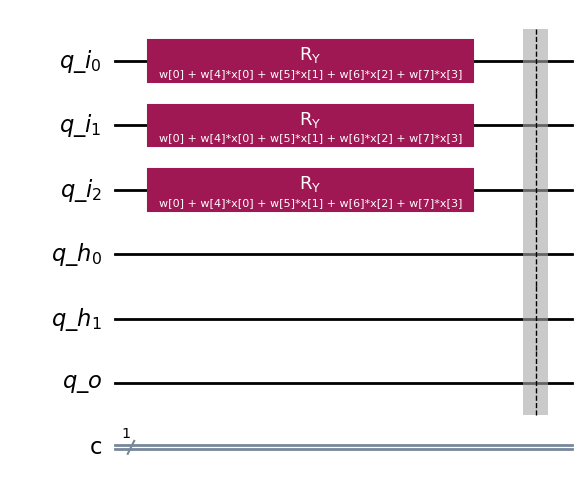

In [21]:
# =============
# Define R_y(z)
# =============

theta = params[0]
for i in range(num_input_features):
    theta += x[i] * params[i+num_biases]

qc.ry(theta, q_i)

qc.barrier()

qc.draw(output="mpl")

## Hidden Layer


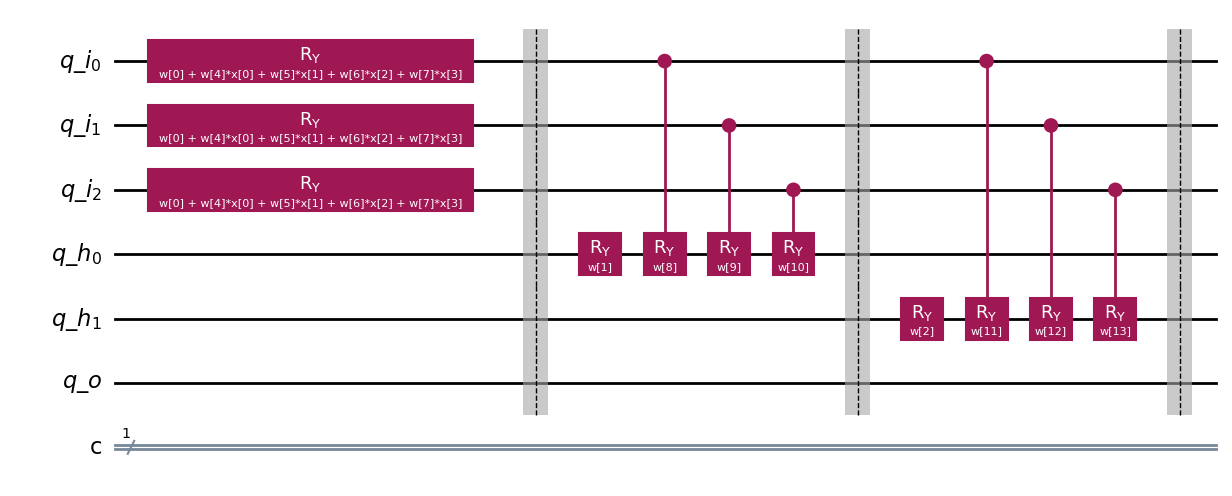

In [22]:
# ==========================================
# Iteravely Define Controlled-Rotation Gates
# ==========================================

for target_idx in range(num_hidden_qubits):
    qc.ry(params[1 + target_idx], q_h[target_idx])
    for control_idx in range(num_input_qubits):
        qc.cry(params[num_biases + num_input_features + control_idx + 
                      target_idx * num_input_qubits], q_i[control_idx], q_h[target_idx])
    qc.barrier()

qc.draw(output="mpl")

## Output Layer


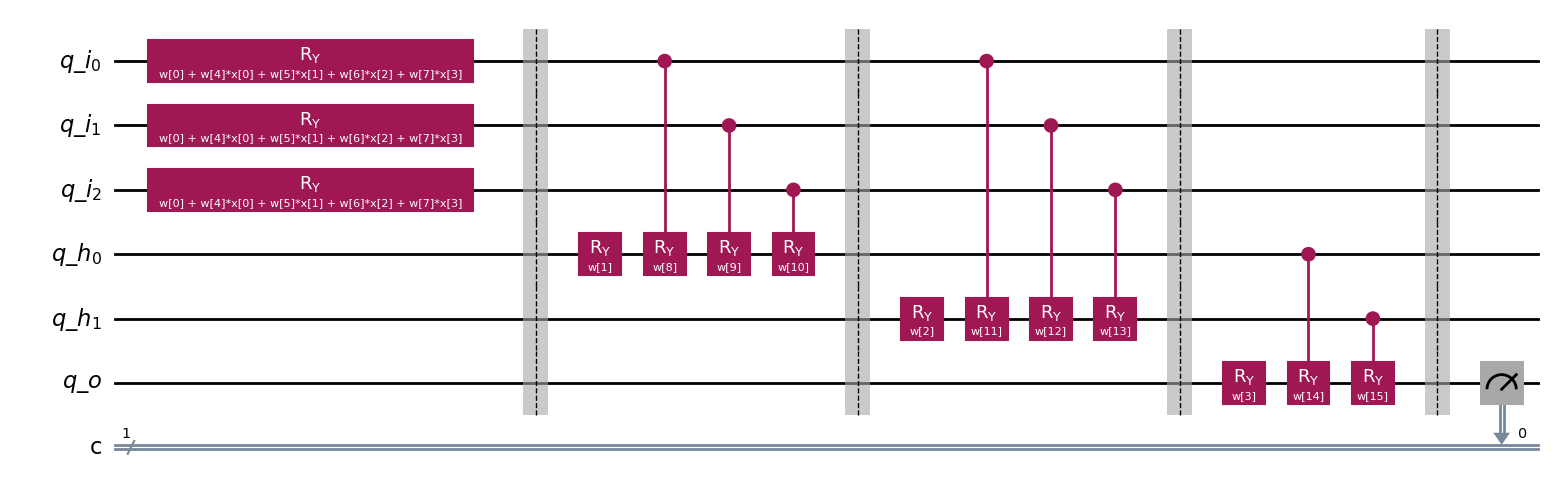

In [ ]:
# ==========================================
# Iteravely Define Controlled-Rotation Gates
# ==========================================S

for target_idx in range(num_output_qubits):
    qc.ry(params[1 + num_hidden_qubits], q_o[target_idx])
    for control_idx in range(num_hidden_qubits):
        qc.cry(params[num_biases + num_input_features + num_input_qubits * num_hidden_qubits + 
                      control_idx + target_idx * num_hidden_qubits], q_h[control_idx], q_o[target_idx])
    qc.barrier()

for i in range(num_output_qubits):
    qc.measure(q_o[i], c[i])

qc.draw(output="mpl")

## Export QuantumCircuit to .qpy File


In [24]:
with open("cffqnn.qpy", "wb") as file: 
    qpy.dump(qc, file)